# Character-Level LSTM in PyTorch

In [7]:
# !pip install datasets
!pip install -U datasets
!pip install zstandard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.1 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    Uninstalling datasets-2.14.4:
      Successfully uninstalled datasets-2.14.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; pla

In [8]:
from huggingface_hub import notebook_login
notebook_login()

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
os.makedirs('/content/drive/MyDrive/test_folder', exist_ok=True)
print("Test folder created in Google Drive.")

Test folder created in Google Drive.


In [ ]:
from datasets import load_dataset

dataset_name = "unshuffled_deduplicated_en"

dataset = load_dataset("oscar-corpus/OSCAR-2201", language="en", split="train", streaming=True)
dataset = dataset.take(5000)

text_lines = []
for d in dataset:
  text_lines.append(d['text'])

single_text_string = "".join(text_lines)


In [11]:
from datasets import load_dataset

dataset_name = "unshuffled_deduplicated" # Remove "en" from the name if you want to load multiple languages

# Load datasets for multiple languages
languages = ["en", "es", "fr"]
datasets = {}
for lang in languages:
  datasets[lang] = load_dataset("oscar-corpus/OSCAR-2201", language=lang, split="train", streaming=True)
  datasets[lang] = datasets[lang].take(2500)

# Combine the text from different languages
text_lines = []
for lang in languages:
    for d in datasets[lang]:
        text_lines.append(d['text'])

single_text_string = "".join(text_lines)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/31.5k [00:00<?, ?B/s]

OSCAR-2201.py:   0%|          | 0.00/19.9k [00:00<?, ?B/s]

The repository for oscar-corpus/OSCAR-2201 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/oscar-corpus/OSCAR-2201.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


In [12]:
single_text_string[:100]

'Founded in 2015, Golden Bees is a leading programmatic recruitment platform dedicated to employers, '

In [13]:
import re
import unicodedata

def normalize_text(text, lowercase=True, allowed_chars=None):
    # Apply Unicode NFKC normalization first
    text = unicodedata.normalize("NFKC", text)

    if lowercase:
        text = text.lower()
    if allowed_chars is not None:
        text = ''.join([ch for ch in text if ch in allowed_chars])
    else:
        # Default: keep lowercase letters, digits, basic punctuation, and whitespace
        text = re.sub(r"[^a-z0-9 .,;:!?'\"\n]", '', text)
    # Standardize whitespace
    text = re.sub(r' +', ' ', text)
    text = re.sub(r'\n+', '\n', text)
    return text

# Allowed_chars for English, Spanish, and French
allowed_chars = "abcdefghijklmnopqrstuvwxyz0123456789 .,;:!?'"
# Spanish and French specific characters
allowed_chars += "áéíóúüñ¡¿àèìòùçéèêëàâäôöûüîï"
normalized_text_string = normalize_text(single_text_string, lowercase=True, allowed_chars=allowed_chars)

In [14]:
len(normalized_text_string)

40776269

In [8]:
normalized_text_string[:100]


'founded in 2015, golden bees is a leading programmatic recruitment platform dedicated to employers, '

In [9]:
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F

In [10]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers):
        super(CharLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden):
        x = self.embedding(x)
        output, hidden = self.lstm(x, hidden)
        output = self.fc(output)
        return output, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, batch_size, self.hidden_dim))


chars = sorted(set(normalized_text_string))
vocab_size = len(chars)
embedding_dim = 128
hidden_dim = 256
num_layers = 2

model = CharLSTM(vocab_size=vocab_size,
                 embedding_dim=embedding_dim,
                 hidden_dim=hidden_dim,
                 num_layers=num_layers)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

model

CharLSTM(
  (embedding): Embedding(70, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=70, bias=True)
)

In [ ]:
# batch_size = 128
# seq_length = 30
n_epochs = 10 # start smaller if you are just testing initial behavior

In [11]:
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm

# Custom dataset class
class CharDataset(Dataset):
    def __init__(self, text, seq_length):
        self.text = text
        self.seq_length = seq_length
        self.vocab_size = len(set(text))
        self.char2idx = {char: idx for idx, char in enumerate(sorted(set(text)))}
        self.idx2char = {idx: char for char, idx in self.char2idx.items()}
        self.encoded_text = [self.char2idx[c] for c in text]

    def __len__(self):
        return len(self.encoded_text) - self.seq_length

    def __getitem__(self, idx):
        x = self.encoded_text[idx:idx+self.seq_length]
        y = self.encoded_text[idx+1:idx+self.seq_length+1]
        return torch.tensor(x), torch.tensor(y)

In [ ]:


# Define the directory to save checkpoints
checkpoint_dir = '/content/drive/MyDrive/test_folder/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define dataset and DataLoader
seq_length = 100
batch_size = 64
dataset = CharDataset(normalized_text_string, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# Modify training loop to use DataLoader
epochs = 5
epoch_losses = []

for epoch in range(epochs):
    # hidden = model.init_hidden(batch_size)
    total_loss = 0
    hidden = tuple(h.to(device) for h in hidden)
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        hidden = tuple(h.detach() for h in hidden)

        model.zero_grad()
        output, hidden = model(x, hidden)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(dataloader)
    epoch_losses.append(average_loss)

    print(f'Epoch {epoch+1}/{epochs} - Loss: {loss.item()}')

    # Save the model checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'model2_epoch_{epoch+1}.pt')
    checkpoint = {
        'vocab_size': vocab_size,
        'embedding_dim': 128,
        'hidden_dim': 256,
        'num_layers': 2,
        'state_dict': model.state_dict(),
        'char2idx': dataset.char2idx, # Also good to save character mappings
        'idx2char': dataset.idx2char
    }
    torch.save(checkpoint, checkpoint_path)
    print(f'Model checkpoint saved to {checkpoint_path}')

100%|██████████| 643756/643756 [3:13:05<00:00, 55.57it/s]


Epoch 1/5 - Loss: 1.5651458501815796
Model checkpoint saved to /content/drive/MyDrive/test_folder/checkpoints/model2_epoch_1.pt


100%|██████████| 643756/643756 [3:11:36<00:00, 56.00it/s]


Epoch 2/5 - Loss: 1.5712006092071533
Model checkpoint saved to /content/drive/MyDrive/test_folder/checkpoints/model2_epoch_2.pt


100%|██████████| 643756/643756 [3:10:38<00:00, 56.28it/s]


Epoch 3/5 - Loss: 1.659069538116455
Model checkpoint saved to /content/drive/MyDrive/test_folder/checkpoints/model2_epoch_3.pt


100%|██████████| 643756/643756 [3:09:02<00:00, 56.75it/s]


Epoch 4/5 - Loss: 2.548321485519409
Model checkpoint saved to /content/drive/MyDrive/test_folder/checkpoints/model2_epoch_4.pt


 90%|█████████ | 581759/643756 [2:49:40<18:10, 56.83it/s]

In [13]:
# Resume
import os
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn # Assuming you have this import

# ... (Define CharLSTM class and other necessary imports)
# ... (Define CharDataset class)

# Define the directory to save checkpoints
checkpoint_dir = '/content/drive/MyDrive/test_folder/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Define dataset and DataLoader
seq_length = 100
batch_size = 64
# Make sure normalized_text_string is available from your data loading step
dataset = CharDataset(normalized_text_string, seq_length)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# Define model parameters (should match the checkpoint)
vocab_size = len(dataset.char2idx) # Use vocab size from the loaded dataset
embedding_dim = 128
hidden_dim = 256
num_layers = 2

# Instantiate the model
model = CharLSTM(vocab_size=vocab_size,
                 embedding_dim=embedding_dim,
                 hidden_dim=hidden_dim,
                 num_layers=num_layers)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

# --- Load the checkpoint ---
checkpoint_path = os.path.join(checkpoint_dir, 'model2_epoch_4.pt') # Specify the checkpoint to load

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)

    # Load model state dictionary
    model.load_state_dict(checkpoint['state_dict']) # Assuming you saved only model.state_dict()


    # If you saved the optimizer state, load it too (highly recommended for continued training)
    # If you didn't save the optimizer state, training will start with a fresh optimizer state
    # which might affect the learning rate schedule if you are using one.
    # Example of loading optimizer state (assuming you saved it in the checkpoint dict)
    # if 'optimizer_state_dict' in checkpoint:
    #     optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    print("Checkpoint loaded successfully.")
else:
    print(f"No checkpoint found at {checkpoint_path}. Starting training from scratch.")

# --- Resume training ---
epochs_to_train_more = 6 # Specify how many more epochs to train
starting_epoch = 4 # Or load this from checkpoint if you saved it

epoch_losses = [] # Initialize list for new epoch losses

for epoch in range(starting_epoch, starting_epoch + epochs_to_train_more):
    total_loss = 0
    # You might need to initialize hidden state based on your model's needs
    # If your model carries state across batches within an epoch, you'll need to handle this.
    # For this simple character LSTM, initializing hidden state at the start of each epoch is common.
    hidden = model.init_hidden(batch_size) # Re-initialize hidden state for the new epoch
    hidden = tuple(h.to(device) for h in hidden)


    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        hidden = tuple(h.detach() for h in hidden)

        model.zero_grad()
        output, hidden = model(x, hidden)
        loss = criterion(output.view(-1, vocab_size), y.view(-1))

        total_loss += loss.item()

        loss.backward()
        optimizer.step()

    average_loss = total_loss / len(dataloader)
    epoch_losses.append(average_loss)

    print(f'Epoch {epoch+1}/{starting_epoch + epochs_to_train_more} - Loss: {average_loss:.4f}')

    # Save checkpoint after each resumed epoch
    # checkpoint_path_resumed = os.path.join(checkpoint_dir, f'model_epoch_{epoch+1}.pt')
    # Consider saving the optimizer state too if you want true resumption
    checkpoint_path = os.path.join(checkpoint_dir, f'model2_epoch_{epoch+1}.pt')
    checkpoint = {
        'vocab_size': vocab_size,
        'embedding_dim': 128,
        'hidden_dim': 256,
        'num_layers': 2,
        'state_dict': model.state_dict(),
        'char2idx': dataset.char2idx, # Also good to save character mappings
        'idx2char': dataset.idx2char
    }
    torch.save(checkpoint, checkpoint_path) # Saving just model state for simplicity
    print(f'Model checkpoint saved to {checkpoint_path}')

Loading checkpoint from /content/drive/MyDrive/test_folder/checkpoints/model2_epoch_4.pt
Checkpoint loaded successfully.


100%|██████████| 643756/643756 [3:10:04<00:00, 56.45it/s]


Epoch 5/10 - Loss: 2.5300
Model checkpoint saved to /content/drive/MyDrive/test_folder/checkpoints/model2_epoch_5.pt


100%|██████████| 643756/643756 [3:09:40<00:00, 56.57it/s]


Epoch 6/10 - Loss: 2.5490
Model checkpoint saved to /content/drive/MyDrive/test_folder/checkpoints/model2_epoch_6.pt


100%|██████████| 643756/643756 [3:08:45<00:00, 56.84it/s]


Epoch 7/10 - Loss: 2.5792
Model checkpoint saved to /content/drive/MyDrive/test_folder/checkpoints/model2_epoch_7.pt


 26%|██▌       | 167624/643756 [49:06<2:19:28, 56.89it/s]


KeyboardInterrupt: 

In [ ]:
model

CharLSTM(
  (embedding): Embedding(45, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=45, bias=True)
)

In [ ]:
model_dir='/content/drive/MyDrive/test_folder'

# change the name, for saving multiple files
model_name = "model_5_epochs_1000.pt" # 'rnn_20_epoch.net'
model_path = os.path.join(model_dir, model_name)

checkpoint = {
        'vocab_size': vocab_size,
        'embedding_dim': 128,
        'hidden_dim': 256,
        'num_layers': 2,
        'state_dict': model.state_dict(),
        'char2idx': dataset.char2idx, # Also good to save character mappings
        'idx2char': dataset.idx2char
}

with open(model_path, 'wb') as f:
    torch.save(checkpoint, f)

### Loading a checkpoint

In [ ]:
# Here we have loaded in a model that trained over 20 epochs `rnn_20_epoch.net`
model_dir='/content/drive/MyDrive/test_folder/checkpoints'
model_name = "model_epoch_5.pt" # 'rnn_20_epoch.net'
model_path = os.path.join(model_dir, model_name)

with open(model_path, 'rb') as f:
    checkpoint = torch.load(f, map_location=device)

chars = sorted(set(normalized_text_string))
vocab_size = len(chars)
embedding_dim = 128
hidden_dim = 256
num_layers = 2

# model = CharLSTM(checkpoint['vocab_size'], checkpoint['embedding_dim'], checkpoint['hidden_dim'], checkpoint['num_layers'])
model = CharLSTM(vocab_size, embedding_dim, hidden_dim, num_layers)
# model.load_state_dict(checkpoint['state_dict'])
model.load_state_dict(checkpoint)
model.to(device)

CharLSTM(
  (embedding): Embedding(45, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=45, bias=True)
)

-----

In [ ]:
def predict_top_chars(model, input_text, char2idx, idx2char, top_k=3, hidden=None):
    input_seq = torch.tensor([char2idx[c] for c in input_text]).unsqueeze(0).to(device)

    if hidden is None:
        hidden = (torch.zeros(model.num_layers, 1, model.hidden_dim).to(device),
                  torch.zeros(model.num_layers, 1, model.hidden_dim).to(device))

    output, hidden = model(input_seq, hidden)

    last_output = output[:, -1, :]  # Get predictions for last character
    top_indices = torch.topk(last_output, top_k).indices.squeeze().tolist()  # Get top-k indices

    predicted_chars = [idx2char[idx] for idx in top_indices]  # Convert indices to characters

    return predicted_chars, hidden

In [ ]:
def calculate_success_rate(model, inputs, ground_truths, char2idx, idx2char, top_k=3):
    successful_predictions = 0
    total_predictions = len(inputs)

    model.eval()
    with torch.no_grad():
        for input_text, ground_truth_char in zip(inputs, ground_truths):
            input_text = normalize_text(input_text, lowercase=True, allowed_chars=allowed_chars)
            # Get the top-k predicted characters
            predicted_chars, _ = predict_top_chars(model, input_text, char2idx, idx2char, top_k=top_k)

           # Check if the ground truth character is in the top-k predictions
            is_successful = ground_truth_char in predicted_chars
            if is_successful:
                successful_predictions += 1

            print(f"Input: '{input_text}' -> Ground Truth: '{ground_truth_char}' -> Predicted (Top-{top_k}): {predicted_chars} -> Success: {is_successful}")

    average_success_rate = (successful_predictions / total_predictions) * 100 if total_predictions > 0 else 0
    return average_success_rate

# Your input and ground truth data
inputs = [
    "Happ",
    "Happy Ne",
    "Happy New Yea",
    "That’s one small ste",
    "That’s one sm",
    "That’",
    "Th",
    "one giant leap for mankin",
    "one giant leap fo",
    "one giant lea",
    "one giant l",
    "one gia",
    "on"
]

ground_truths = [
    "y",
    "w",
    "r",
    "p",
    "a",
    "s",
    "a",
    "d",
    "r",
    "p",
    "e",
    "n",
    "e"
]

# Add Spanish examples
spanish_inputs = [
    "Hol",
    "¿Cómo est",
    "Graci",
    "Por favo",
    "Buen",
]

spanish_ground_truths = [
    "a",
    "á",
    "a",
    "r",
    "o",
]

# Add French examples
french_inputs = [
    "Bonjou",
    "Comme",
    "Merci bea",
    "S'il vous pla",
    "Au revoi",
]

french_ground_truths = [
    "r",
    "nt",
    "u",
    "î",
    "r",
]

# Combine all inputs and ground truths
all_inputs = inputs + spanish_inputs + french_inputs
all_ground_truths = ground_truths + spanish_ground_truths + french_ground_truths

# Make sure you have char2idx and idx2char from your training data
# For example, using the mappings from your trained model:
char2idx = {char: idx for idx, char in enumerate(sorted(set(normalized_text_string)))}
idx2char = {idx: char for char, idx in char2idx.items()}


# Calculate the success rate
top_k_value = 3 # You can change this to 1 for top-1 accuracy
success_rate = calculate_success_rate(model, all_inputs, all_ground_truths, char2idx, idx2char, top_k=top_k_value)

print(f"Average Success Rate (Top-{top_k_value}): {success_rate:.2f}%")

Input: 'happ' -> Ground Truth: 'y' -> Predicted (Top-3): ['i', 'e', 'r'] -> Success: False
Input: 'happy ne' -> Ground Truth: 'w' -> Predicted (Top-3): ['e', 'y', 'w'] -> Success: True
Input: 'happy new yea' -> Ground Truth: 'r' -> Predicted (Top-3): ['r', 's', 'h'] -> Success: True
Input: 'that's one small ste' -> Ground Truth: 'p' -> Predicted (Top-3): ['p', 'l', 'a'] -> Success: True
Input: 'that's one sm' -> Ground Truth: 'a' -> Predicted (Top-3): ['s', 'a', 'l'] -> Success: True
Input: 'that'' -> Ground Truth: 's' -> Predicted (Top-3): ['s', 'y', 'l'] -> Success: True
Input: 'th' -> Ground Truth: 'a' -> Predicted (Top-3): ['y', 'e', 'o'] -> Success: False
Input: 'one giant leap for mankin' -> Ground Truth: 'd' -> Predicted (Top-3): ['d', 'g', ' '] -> Success: True
Input: 'one giant leap fo' -> Ground Truth: 'r' -> Predicted (Top-3): ['r', 'l', 'u'] -> Success: True
Input: 'one giant lea' -> Ground Truth: 'p' -> Predicted (Top-3): ['v', 'd', 'r'] -> Success: False
Input: 'one giant l' -> Ground Truth: 'e' -> Predicted (Top-3): ['i', 'o', 'e'] -> Success: True
Input: 'one gia' -> Ground Truth: 'n' -> Predicted (Top-3): ['n', 'o', 'h'] -> Success: True
Input: 'on' -> Ground Truth: 'e' -> Predicted (Top-3): [' ', 'e', '.'] -> Success: True
Average Success Rate (Top-3): 76.92%

In [1]:
epoch_losses = [
    1.5651458501815796,
    1.5712006092071533,
    1.659069538116455,
    2.548321485519409,
    2.5300,
    2.5490,
    2.5792
]

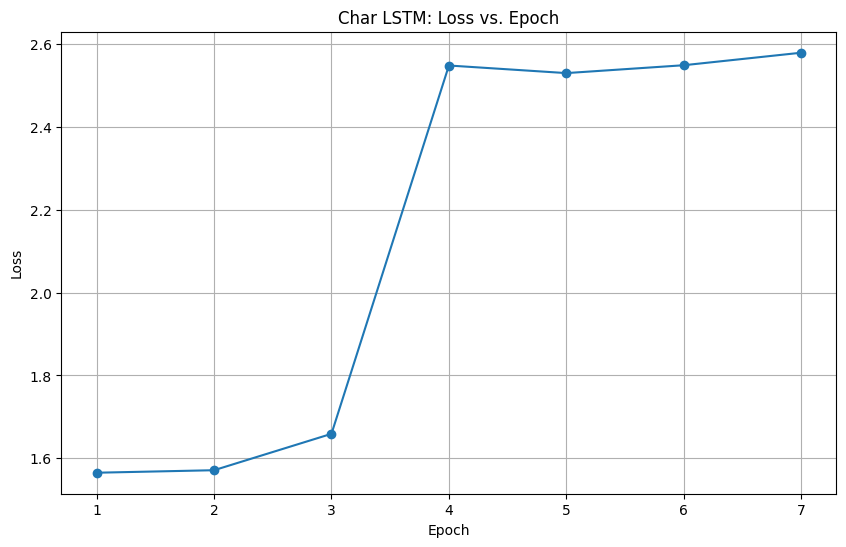

In [5]:
import matplotlib.pyplot as plt

# Assuming epoch_losses list contains the average loss for each epoch
# and epochs variable holds the total number of epochs you've trained for

# Create a list of epoch numbers
epochs_list = range(1, len(epoch_losses) + 1)

# Plot the loss
plt.figure(figsize=(10, 6))
plt.plot(epochs_list, epoch_losses, marker='o', linestyle='-')
plt.title('Char LSTM: Loss vs. Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.xticks(epochs_list) # Ensure all epochs are shown on the x-axis
plt.show()